# MAST30034 (Applied Data Science) Assignment 1
## Zhi Hern Tom 1068268

In [2]:
import numpy as np
from numpy.linalg import inv
from numpy.linalg import norm
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

## Question 1: Synthetic dataset generation, data preporcessing, & data visualization

### Q 1.1) 
Construct a matrix TC of size 240 × 6 consisting of six temporal sources using three vectors, 1) onsets arrival vector (AV) = [0,20,0,0,0,0], 2) increment vector (IV) = [30,45,60,40,40,40], and 3) duration of ones = [15,20,25,15,20,25]. For instance, you can generate first TC using these three vectors as AV:IV:N-20 =0:30:220 and ones stay active for 15 samples, and N here is 240. This TC is also shown in Figure 1 (left). Mean center each TC by subtracting its mean and standardize each TC by dividing it by its standard deviation. This will make TCs bias free (centered around the origin) and equally important (have unit variance). Plot all TCs as six subplots. Why not normalize (divide by l-2 norm) the TCs instead of standardizing it?

In [3]:
def create_TC(AV, IV, DOO, nrow=240):
    """
    ----------
    Parameters
    ----------
    AV   : onsets arrival vector
    IV   : increment vector
    DOO  : duration of ones
    nrow : number of rows (240 by default)
    
    Returns
    -------
    TC matrix (nrow x 1)
    """
    
    ONE = 1
    ZERO = 0
    matrix = []
    # insert zero if arrival vector > 0
    for i in range(AV):
        matrix.append(ZERO)
    while len(matrix) < nrow:
        # one
        for i in range(DOO):
            matrix.append(ONE)
            if len(matrix) >= nrow:
                return matrix
        # zero
        for i in range(IV - DOO):
            matrix.append(ZERO)
            if len(matrix) >= nrow:
                return matrix

    return matrix

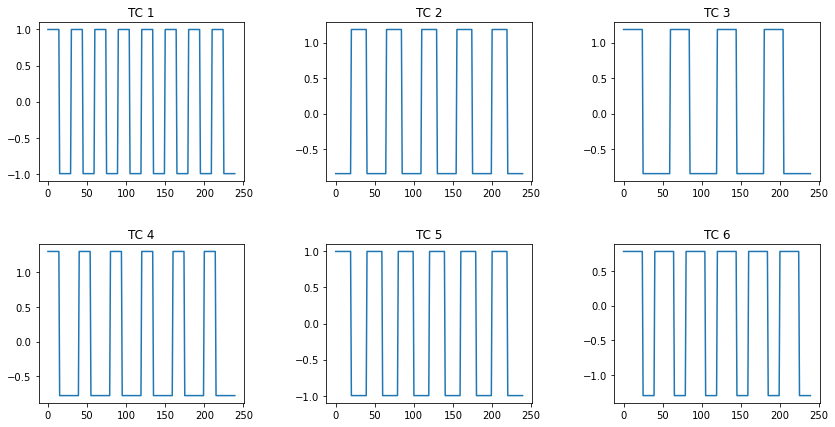

In [4]:
AVs = [0, 20, 0, 0, 0, 0]
IVs = [30, 45, 60, 40, 40, 40]
DOOs = [15, 20, 25, 15, 20, 25]
TC = []
for AV, IV, DOO in zip(AVs, IVs, DOOs):
    matrix = create_TC(AV, IV, DOO) # create matrix
    matrix_standard = scale(matrix) # standardize it
    TC.append(matrix_standard)  # append matrix
TC = np.array(TC).T   # transpose it

# Plot figures for all matrix TC
fig = plt.figure(figsize=(14, 7))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 7):
    ax = fig.add_subplot(2, 3, i)
    ax.set_title("TC " + str(i))
    plt.plot(TC[:,i-1])
plt.savefig('plots/q1.1.png')
plt.show()

### Q 1.2)
A randomly generated correlation matrix (CM) (illustrating uncorrelatedness among all variables) is shown as a sample in Figure 1 (middle). For your case, construct a CM that represents correlation values between 6 variables. Show its plot, and can you tell visually which two TCs are highly correlated? If not, can you tell this from CM?

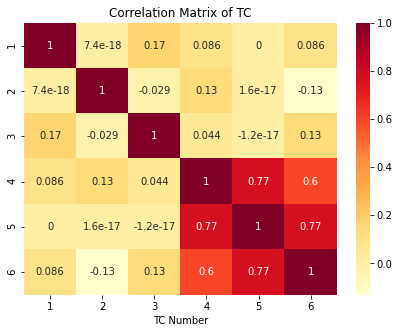

In [5]:
plt.figure(figsize=(7, 5))
sns.heatmap(np.corrcoef(TC.T), xticklabels=list(range(1,TC.shape[1]+1)), yticklabels=list(range(1,TC.shape[1]+1)), cmap='YlOrRd', annot=True)
plt.title('Correlation Matrix of TC')
plt.xlabel('TC Number')
plt.savefig('plots/q1.2.png')
plt.show()

### Q 1.3) 
Construct an array tmpSM of size 6×(21×21) consisting of ones and zeros, by placing ones at these pixels along ”vertical,horizontal” direction of the slice i) 02:06,02:06, ii) 02:06,15:19, iii) 08:13,02:06, iv) 08:13,15:19, v) 15:19,02:06, vi) 15:19,15:19. The first SM source is also shown in Figure 1 (right). Plot these SMs in six subplots. Reshape the array tmpSM into a two dimensional matrix and call it SM of size 6 × 441. Using CM show if these 6 vectored SMs are independent? For our particular case, why standardization of SMs like TCs is not important? Hint: Imagine one of the slice has pixel values of 5, while others remain at 1.

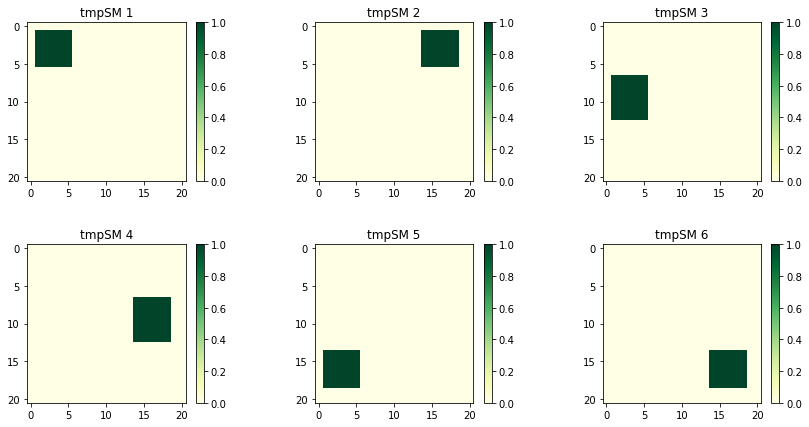

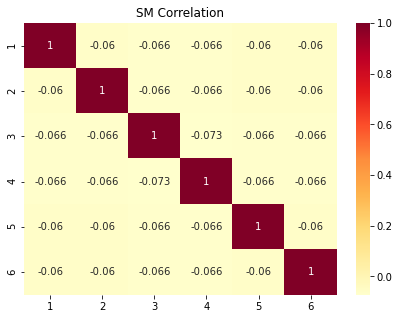

In [6]:
# Construct tmpSM
tmpSM = np.zeros((6, 21,21))
one_direction = np.array([[[1, 6], [1, 6]], [[1, 6], [14, 19]], [[7, 13], [1, 6]], [[7, 13], [14, 19]], [[14, 19], [1, 6]], [[14, 19], [14, 19]]])
ONE = 1

## replace by one given the direction
for i in range(len(tmpSM)):
    vert = one_direction[i][0]
    horiz = one_direction[i][1]
    tmpSM[i][vert[0]:vert[1], horiz[0]:horiz[1]] = ONE

# Plot figures for tmpSM
fig = plt.figure(figsize=(14, 7))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 7):
    ax = fig.add_subplot(2, 3, i)
    ax.set_title("tmpSM " + str(i))
    plt.imshow(tmpSM[i-1], cmap='YlGn')
    plt.colorbar()
plt.savefig('plots/q1.3a.png')
plt.show()

# Convert to 2d (6 x 441)
SM = []
n = tmpSM.shape[0]
for i in range(n):
    SM.append(tmpSM[i].flatten(order='F'))
SM = np.array(SM)

plt.figure(figsize=(7, 5))
labels = list(range(1,SM.shape[0]+1))
sns.heatmap(np.corrcoef(SM), xticklabels=labels, yticklabels=labels, cmap='YlOrRd', annot=True)
plt.title('SM Correlation')
plt.savefig('plots/q1.3b.png')
plt.show()

### Q 1.4)
Generate zero mean white Gaussian noise for temporal and spatial sources denoted as Γt ∈ R240×6 and Γs ∈ R6×441. Besides their dimensions, another difference between spatial and temporal noise is the noise variance, which is 0.25 for Γt, and 0.015 for Γs. Using a 6 × 6 CM for each noise type (spatial and temporal) can you show if they are correlated across sources? Also plot the histogram of both noise sources to see if they have a normal distribution? Does this normal distribution fulfils the mean and variance= 1.96σ criteria relating to 0.25, 0.015, and zero mean? Is there product ΓtΓs correlated across V number of variables?

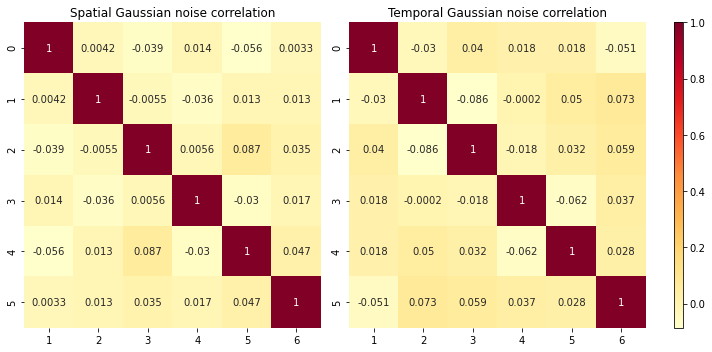

In [7]:
# Generate noise
var_t = 0.25
var_s = 0.015
np.random.seed(0)
gamma_t = np.random.normal(0, np.sqrt(var_t), size = (240, 6))
np.random.seed(1)
gamma_s = np.random.normal(0, np.sqrt(var_s), size = (6, 441))

# Plot figure
fig, axs = plt.subplots(1, 3, figsize=(10,5), gridspec_kw=dict(width_ratios=[1,1,0.03]))

# Spatial gaussian noise correlation
sns.heatmap(np.corrcoef(gamma_s), xticklabels=list(range(1, gamma_s.shape[0]+1)), cmap='YlOrRd', ax = axs[0], cbar=False, annot=True)
axs[0].set_title('Spatial Gaussian noise correlation')

# Temporal gaussian noise correlation
sns.heatmap(np.corrcoef(gamma_t.T), xticklabels=list(range(1, gamma_t.shape[1]+1)), cmap='YlOrRd', ax = axs[1], cbar=False, annot=True)
axs[1].set_title('Temporal Gaussian noise correlation')

fig.colorbar(axs[1].collections[0], cax=axs[2])
fig.tight_layout()
plt.savefig('plots/q1.4a.png')
plt.show()

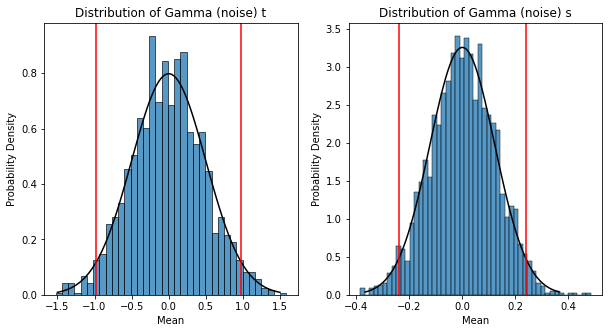

COMMENT:
Yes, this normal distribution fulfils the mean and variance= 1.96σ criteria relating to 0.25, 0.015, and zero mean.


In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

sns.histplot(ax=axs[0], x=gamma_t.flatten(), bins=int(np.sqrt(len(gamma_t.flatten()))), stat='density')
axs[0].set_title('Distribution of Gamma (noise) t')
axs[0].set_ylabel('Probability Density')
axs[0].set_xlabel('Mean')
mu = 0
sigma = np.sqrt(0.25)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
axs[0].plot(x, stats.norm.pdf(x, mu, sigma), color='black')
axs[0].axvline(x=1.96*sigma, color='r', label='1.96 sigma')
axs[0].axvline(x=-1.96*sigma, color='r', label='1.96 sigma')

sns.histplot(ax=axs[1], x=gamma_s.flatten(), bins=int(np.sqrt(len(gamma_s.flatten()))), stat='density')
axs[1].set_title('Distribution of Gamma (noise) s')
axs[1].set_ylabel('Probability Density')
axs[1].set_xlabel('Mean')
mu = 0
sigma = np.sqrt(0.015)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
axs[1].plot(x, stats.norm.pdf(x, mu, sigma), color='black')
axs[1].axvline(x=1.96*sigma, color='r')
axs[1].axvline(x=-1.96*sigma, color='r')
plt.savefig('plots/q1.4b.png')
plt.show()

print('COMMENT:')
print('Yes, this normal distribution fulfils the mean and variance= 1.96σ criteria relating to 0.25, 0.015, and zero mean.')

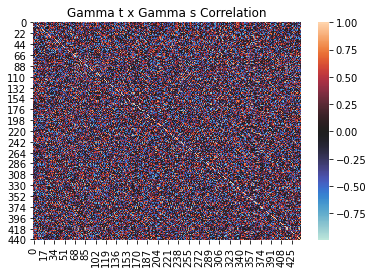

COMMENT:
There is no product ΓtΓs correlated across V number of variables.


In [36]:
# Correlation of Gamma t x Gamma s
gamma_ts = gamma_t @ gamma_s
gamma_ts_corr = np.corrcoef(gamma_ts.T)
sns.heatmap(gamma_ts_corr, cmap = "icefire")
plt.title("Gamma t x Gamma s Correlation")
plt.savefig('plots/q1.4c.png')
plt.show()

print('COMMENT:')
print('There is no product ΓtΓs correlated across V number of variables.')

### Q 1.5)
Generate a synthetic dataset X of size 240 × 441 as X = (TC + Γt) × (SM + Γs). This builds a dataset that follows the model shown in eq (1). Can these products TC × Γs and Γt × SM exist, If yes what happened to them because if we keep them then we cannot fit our model onto (1)? Plot atleast 100 randomly selected time-series from X as few of them are shown in Figure 2 (left). Also plot variance of all 441 variables on a separate plot. What information does this plot give you? At the end standardize the dataset X, because source TCs (regressors) are also standardized and so dataset should be too.

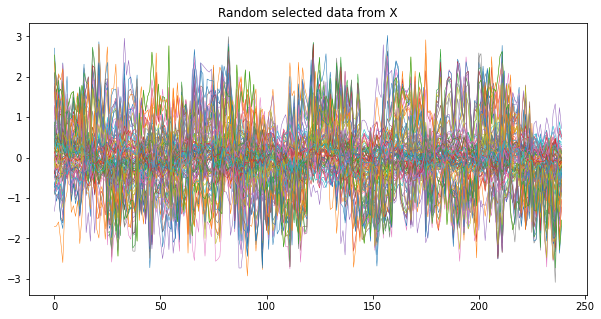

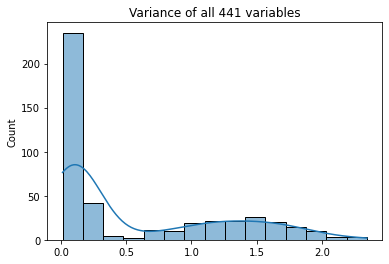

In [37]:
X = (TC + gamma_t) @ (SM + gamma_s)

SIZE = 100
# Select 100 datapoints from X
np.random.seed(3)
samples_index = np.random.randint(441, size = SIZE)
X_sample = X[:, samples_index]

plt.figure(figsize=(10, 5))
plt.plot(X_sample, linewidth=0.5)
plt.title('Random selected data from X')
plt.savefig('plots/q1.5a.png')
plt.show()

# Plot variance of all 411 variables
var = np.var(X, axis=0)
bin_size = int(np.sqrt(len(X)))
sns.histplot(var, bins=bin_size, kde=True)
plt.title('Variance of all 441 variables')
plt.savefig('plots/q1.5b.png')
plt.show()

# Standardize X
X = scale(X)

## Question 2: Data analysis, results visualization, & performance metrics

### Q 2.1)
The synthetic standardized dataset X that you have generated in Question 1 follows the linear regression model X = DA + E where the unknown A can be estimated using least squares. Since the set of regressors D are known as you have used them to generate X, and these were the TCs so D = TC. Estimate A (retrieval of SMs) using least square solution ALSR = (D⊤D)−1D⊤X. Similarly, retrieve TCs in DLSR for a known ALSR using DLSR = XA⊤LSR. Plot six retrieved sources using ALSR and DLSR side by side as shown in Figure 2 (right) for one of the retrieved sources. Do a scatter plot between 3rd column of DLSR and 30th column of standardized X, you will find a linear relationship between them, why this does not exist between 4th column of DLSR and same column of X. Hint: Look at the slices arrangement which source TCs do you think contributed in building 30th data element.

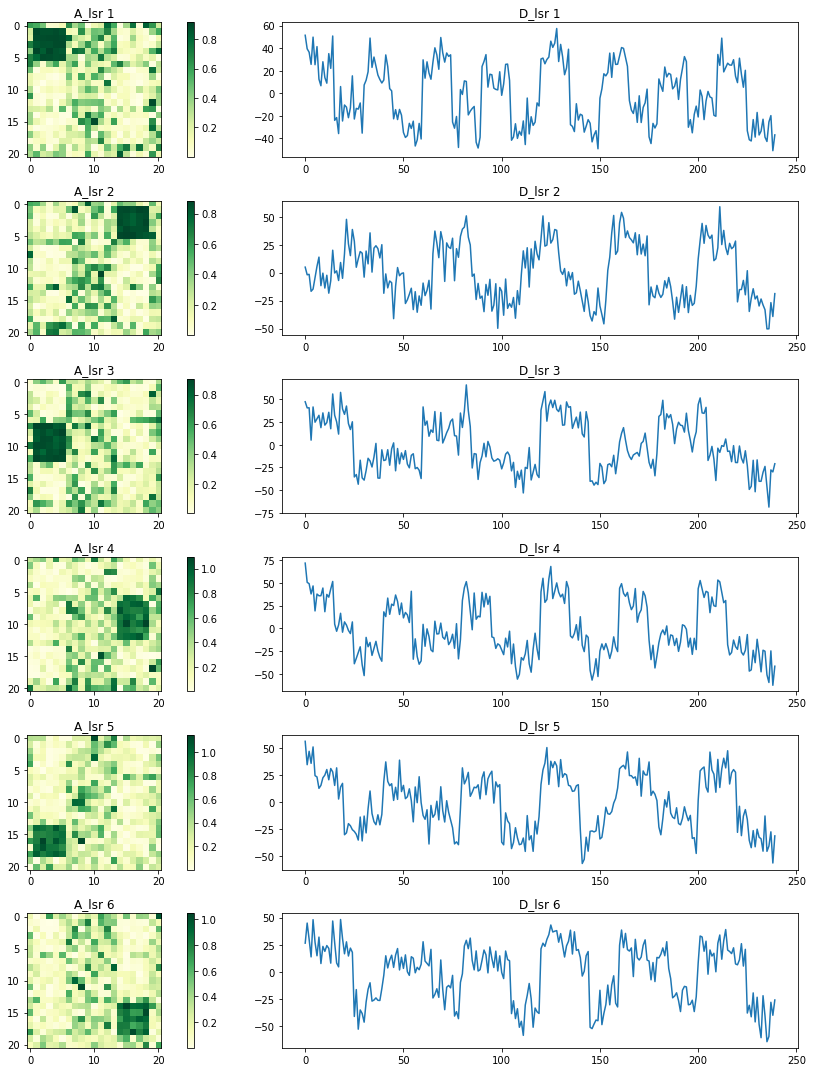

In [50]:
D = TC

# Estimate lsr parameters
A_lsr = np.abs(inv(D.T @ D) @ D.T @ X)
D_lsr = X @ A_lsr.T

# Plot six retrieved sources using A_lsr and D_lsr side by side
fig = plt.figure(figsize=(15, 15))
j = 0
for i in range(6):
    # plot A lsr
    j+=1
    ax = fig.add_subplot(6, 2, j)
    ax.set_title("A_lsr " + str(i+1))
    plt.imshow(A_lsr[i].reshape(21, 21, order='F'), cmap='YlGn')
    plt.colorbar()
    
    # plot D lsr
    j+=1
    ax = fig.add_subplot(6, 2, j)
    ax.set_title("D_lsr " + str(i+1))
    plt.plot(D_lsr[:,i])
plt.tight_layout()
plt.savefig('plots/q2.1a.png')
plt.show()

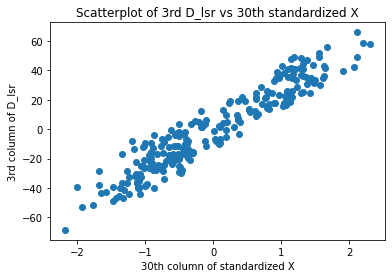

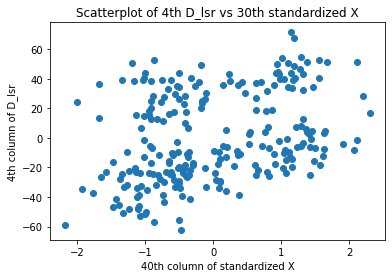

In [39]:
# Plot 3rd column of D_lsr and 30th column of standardized X
D_lsr_3rd = D_lsr[:, 2]
X_30th = X[:, 29]
plt.scatter(y=D_lsr_3rd, x=X_30th)
plt.title('Scatterplot of 3rd D_lsr vs 30th standardized X')
plt.xlabel('30th column of standardized X')
plt.ylabel('3rd column of D_lsr')
plt.savefig('plots/q2.1b.png')
plt.show()

# Plot 4th column of D_lsr and 30th column of standardized X
D_lsr_4th = D_lsr[:, 3]
plt.scatter(y=D_lsr_4th, x=X_30th)
plt.title('Scatterplot of 4th D_lsr vs 30th standardized X')
plt.xlabel('40th column of standardized X')
plt.ylabel('4th column of D_lsr')
plt.savefig('plots/q2.1c.png')
plt.show()

## Q2.2)
Estimate RR parameters ARR = (D⊤D + λ ̃I)−1D⊤X and DRR and then compare RR to LSR by estimating two correlation vectors retaining only maximum absolute correlations i) between each TC and DLSR and store it in cTLSR, and ii) between each TC and DRR and store it in cTRR. Calculate the sum of these two correlation vectors. If you have carefully selected the value of λ between 0 and 1 you must end up with 􏰂cTRR > 􏰂cTLSR, and remember λ ̃ = λV. Also, for λ = 1000, plot first vector from ARR and the corresponding vector from ALSR, Do you find all values in a1RR shrinking towards zero?

In [40]:
def estimate_rr_params(D, X, lmbda, absolute=True):
    """
    ----------
    Parameters
    ----------
    D        : matrix TC
    X        : synthetic dataset (240 x 441 by default)
    lmbda    : penalty constant lambda, aka regularization term for Ridge Regression
    absolute : boolean, if True then A_rr will be absolute value
    
    Returns
    -------
    A_rr : parameter of Ridge Regression, aka Beta (β)
    D_rr : predicted values (y)
    """
    
    V = X.shape[1] # V is the number of observed variables, 441 by default
    I = np.eye(D.shape[1])
    lmbda_hat = lmbda * V
    A_rr = inv(D.T @ D + lmbda_hat * I) @ D.T @ X
    
    if absolute:
        A_rr = np.abs(A_rr)
    
    D_rr = X @ A_rr.T
    
    return A_rr, D_rr

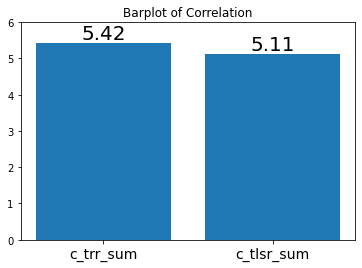

In [49]:
# Calculate the corrrelations
lmbda=0.5
A_rr, D_rr = estimate_rr_params(D, X, lmbda=lmbda, absolute=False)
c_tlsr = []
c_trr = []
for i in range(TC.shape[1]):
    c_tlsr.append(np.abs(np.corrcoef(TC[:, i], D_lsr[:, i])[0][1]))
    c_trr.append(np.abs(np.corrcoef(TC[:, i], D_rr[:, i])[0][1]))

# Sum up the correlation
c_tlsr_sum = np.sum(c_tlsr)
c_trr_sum = np.sum(c_trr)

x = ['c_trr_sum', 'c_tlsr_sum']
y = [c_trr_sum, c_tlsr_sum]
plt.bar(x, y)
plt.ylim([0, 6])
plt.xticks(fontsize=14)
plt.title('Barplot of Correlation')
for i in range(len(x)):
    plt.annotate(np.round(y[i],3), xy=(x[i],y[i]), ha='center', va='bottom', fontsize=20)
plt.savefig('plots/q2.2a.png')
plt.show()

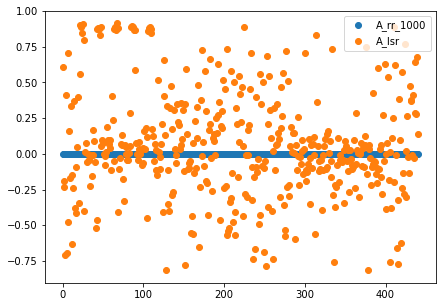

COMMENT:
Yes, all values in A1_rr shrinking towards zero.


In [51]:
# Estimate A_lsr
A_lsr = inv(D.T @ D) @ D.T @ X
# Estimate A_rr using lambda=1000
A_rr_1000, _ = estimate_rr_params(D, X, lmbda=1000, absolute=False)
plt.figure(figsize=(7,5))
plt.scatter(y=A_rr_1000[0, :], x=list(range(len(A_rr_1000[0, :]))), label='A_rr_1000')
plt.scatter(y=A_lsr[0, :], x=list(range(len(A_lsr[0, :]))), label='A_lsr')
plt.legend()
plt.savefig('plots/q2.2b.png')
plt.show()

print('COMMENT:')
print('Yes, all values in A1_rr shrinking towards zero.')

## Q 2.3)
For 21 values of ρ selected between 0 and 1 with an interval of 0.05, estimate LR param- V
eters ALR, DLR, and sum of MSE using LR parameters as 􏰂 ||X − DLRA2LR||2/NV , v=1
and repeat this process 10 times (10 realizations) each time with a new standardized X (new in terms of Γt and Γs). Then plot average of MSE over these 10 realizations against each value of ρ. At what value of ρ do you find the minimum MSE? Is it okay to select this value? At what value of ρ did MSE started to increase again (LR diverged) . Here ||.||2 is the Frobenius norm. Hint: Matlab code for MSE calculation over one realization and one lambda value, here rr=1, first realization, and kk=1, first lambda
MSE(kk,rr) = sum(sum((Y=Dlr*Alr).ˆ2))/(N*V)

In [43]:
def estimate_lr_params(TC, rho, X, absolute=True):
    """
    ----------
    Parameters
    ----------
    TC       : time courses matrix
    rho      : ρ, regularization term for LASSO Regression
    X        : spatiotemporal synthetic dataset
    absolute : boolean, if True then A_lr will be absolute value
    
    Returns
    -------
    A_lr : parameter of LASSO Regression, aka Beta (β)
    D_lr : predicted values (y)
    """
    
    x1 = int(np.sqrt(X.shape[1]))
    x2 = int(np.sqrt(X.shape[1]))
    step = 1/ norm((TC @ TC.T) * 1.1)
    N = X.shape[0]
    thr = rho * N * step
    Ao = np.zeros((nsrcs, 1))
    A = np.zeros((nsrcs, 1))
    A_lr = np.zeros((nsrcs, x1*x2))

    for k in range(x1 * x2):
        A = Ao + step * (TC.T @ (X[:, k].reshape(-1,1) - TC @ Ao))
        A = (1/ (1 + thr)) * (np.sign(A) * np.maximum(np.zeros((nsrcs, 1)), np.abs(A) - thr))
        for i in range(10):
            Ao = A
            A = Ao + step * (TC.T @ (X[:, k].reshape(-1,1) - TC @ Ao))
            A = (1/ (1 + thr)) * (np.sign(A) * np.maximum(np.zeros((nsrcs, 1)), np.abs(A) - thr))
        A_lr[:,k] = A.flatten()
    
    if absolute:
        A_lr = np.abs(A_lr)
    
    D_lr = X @ A_lr.T
    
    return A_lr, D_lr

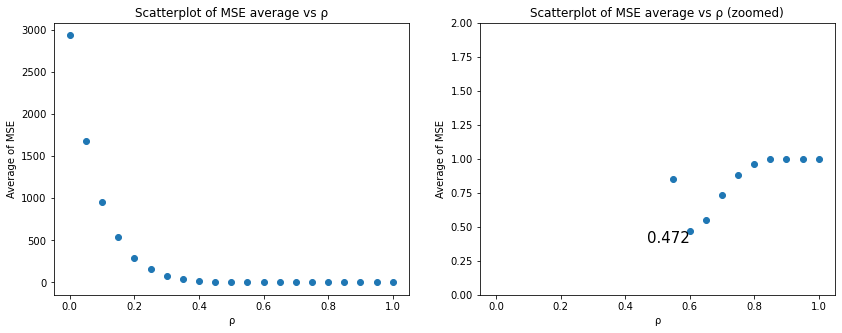

COMMENT:
As we can see it converges at rho = 0.6 and after that the MSE started to increase again.


In [44]:
rhos = np.linspace(0, 1, 21) # list of ρ, regularization term for LASSO Regression
N = X.shape[0] # number of time points, 240 in this case
V = X.shape[1] # number of observed variables, 441 in this case
L = D.shape[1] # number of regressors, 6 in this case
nsrcs = 6 # number of sources, 6 in this case

# Calculate MSE for each rho
MSEs = []
for rho in rhos:  # try each rho
    MSE = 0
    for i in range(10): # repeat 10 times (10 realizations)
        np.random.seed(i + 4)
        gamma_t = np.random.normal(0, np.sqrt(var_t), size = (TC.shape[0], TC.shape[1]))  # generate noise
        np.random.seed(i + 14)
        gamma_s = np.random.normal(0, np.sqrt(var_s), size = (SM.shape[0], SM.shape[1]))  # generate noise
        X_new = (TC + gamma_t) @ (SM + gamma_s)
        X_new = scale(X_new) # standardize X
        A_lr, D_lr = estimate_lr_params(TC=TC, rho=rho, X=X_new, absolute=False)
        MSE += np.sum((X_new - D_lr @ A_lr)**2)/ (N * V)
    MSE = MSE/10
    MSEs.append(MSE)

# Plot average of MSE over these 10 realizations against each value of rho (ρ)
fig, axs = plt.subplots(1, 2, figsize=(14,5))
axs[0].scatter(x=rhos, y=MSEs)
axs[0].set_title('Scatterplot of MSE average vs ρ')
axs[0].set_xlabel('ρ')
axs[0].set_ylabel('Average of MSE')

axs[1].scatter(x=rhos, y=MSEs)
axs[1].set_title('Scatterplot of MSE average vs ρ (zoomed)')
axs[1].set_xlabel('ρ')
axs[1].set_ylabel('Average of MSE')
axs[1].set_ylim([0, 2])

axs[1].annotate(np.round(min(MSEs), 3), xy=(rhos[np.argmin(MSEs)],min(MSEs)), ha='right', va='top', fontsize=15)
plt.savefig('plots/q2.3.png')
plt.show()

print('COMMENT:')
print('As we can see it converges at rho = 0.6 and after that the MSE started to increase again.')

## Q2.4)
Estimate LR parameters for the value of ρ that you have selected in Question 2.3. Now, estimate four correlation vectors retaining only maximum absolute correlations i) between each TC and DRR and store it in cTRR, ii) between each SM and ARR and store it in cSRR, iii) between each TC and DLR and store it in cTLR, and iv) between each SM and ALR and store it in cSLR. Calculate the sum of these four correlation vectors. If you have carefully selected the value of ρ you must end up with 􏰂cTLR > 􏰂cTRR and 􏰂cSLR > 􏰂cSRR. Plot side by side in form of 4 columns estimates of D and A for both RR and LR to know the difference visually. You will see a major difference in estimates of A in terms of false positives. Can you mention the reason behind this difference?

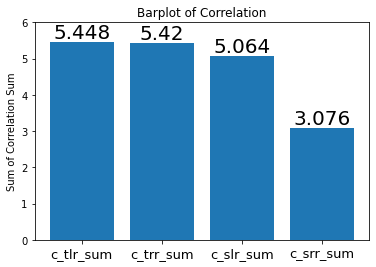

In [45]:
c_trr = []
c_srr = []
c_tlr = []
c_slr = []

rho_opt = rhos[np.argmin(MSEs)] # choose the optimal rho (that results in the lowest MSE)
A_lr, D_lr = estimate_lr_params(TC=TC, rho=rho_opt, X=X, absolute=False)

# Calculate correlation
for i in range(TC.shape[1]):
    c_trr.append(np.abs(np.corrcoef(TC[:, i], D_rr[:, i])[0][1]))
    c_srr.append(np.abs(np.corrcoef(SM[i, :], A_rr[i, :])[0][1]))
    c_tlr.append(np.abs(np.corrcoef(TC[:, i], D_lr[:, i])[0][1]))
    c_slr.append(np.abs(np.corrcoef(SM[i, :], A_lr[i, :])[0][1]))
    
# Sum up the correlation
c_trr_sum = np.sum(c_trr)
c_srr_sum = np.sum(c_srr)
c_tlr_sum = np.sum(c_tlr)
c_slr_sum = np.sum(c_slr)

x = ['c_tlr_sum', 'c_trr_sum', 'c_slr_sum', 'c_srr_sum']
y = [c_tlr_sum, c_trr_sum, c_slr_sum, c_srr_sum]
plt.bar(x, y)
plt.title('Barplot of Correlation')
plt.ylim([0, 6])
plt.ylabel('Sum of Correlation Sum')
plt.xticks(fontsize=13)
for i in range(len(x)):
    plt.annotate(np.round(y[i],3), xy=(x[i],y[i]), ha='center', va='bottom', fontsize=20)
    
plt.savefig('plots/q2.4a.png')
plt.show()

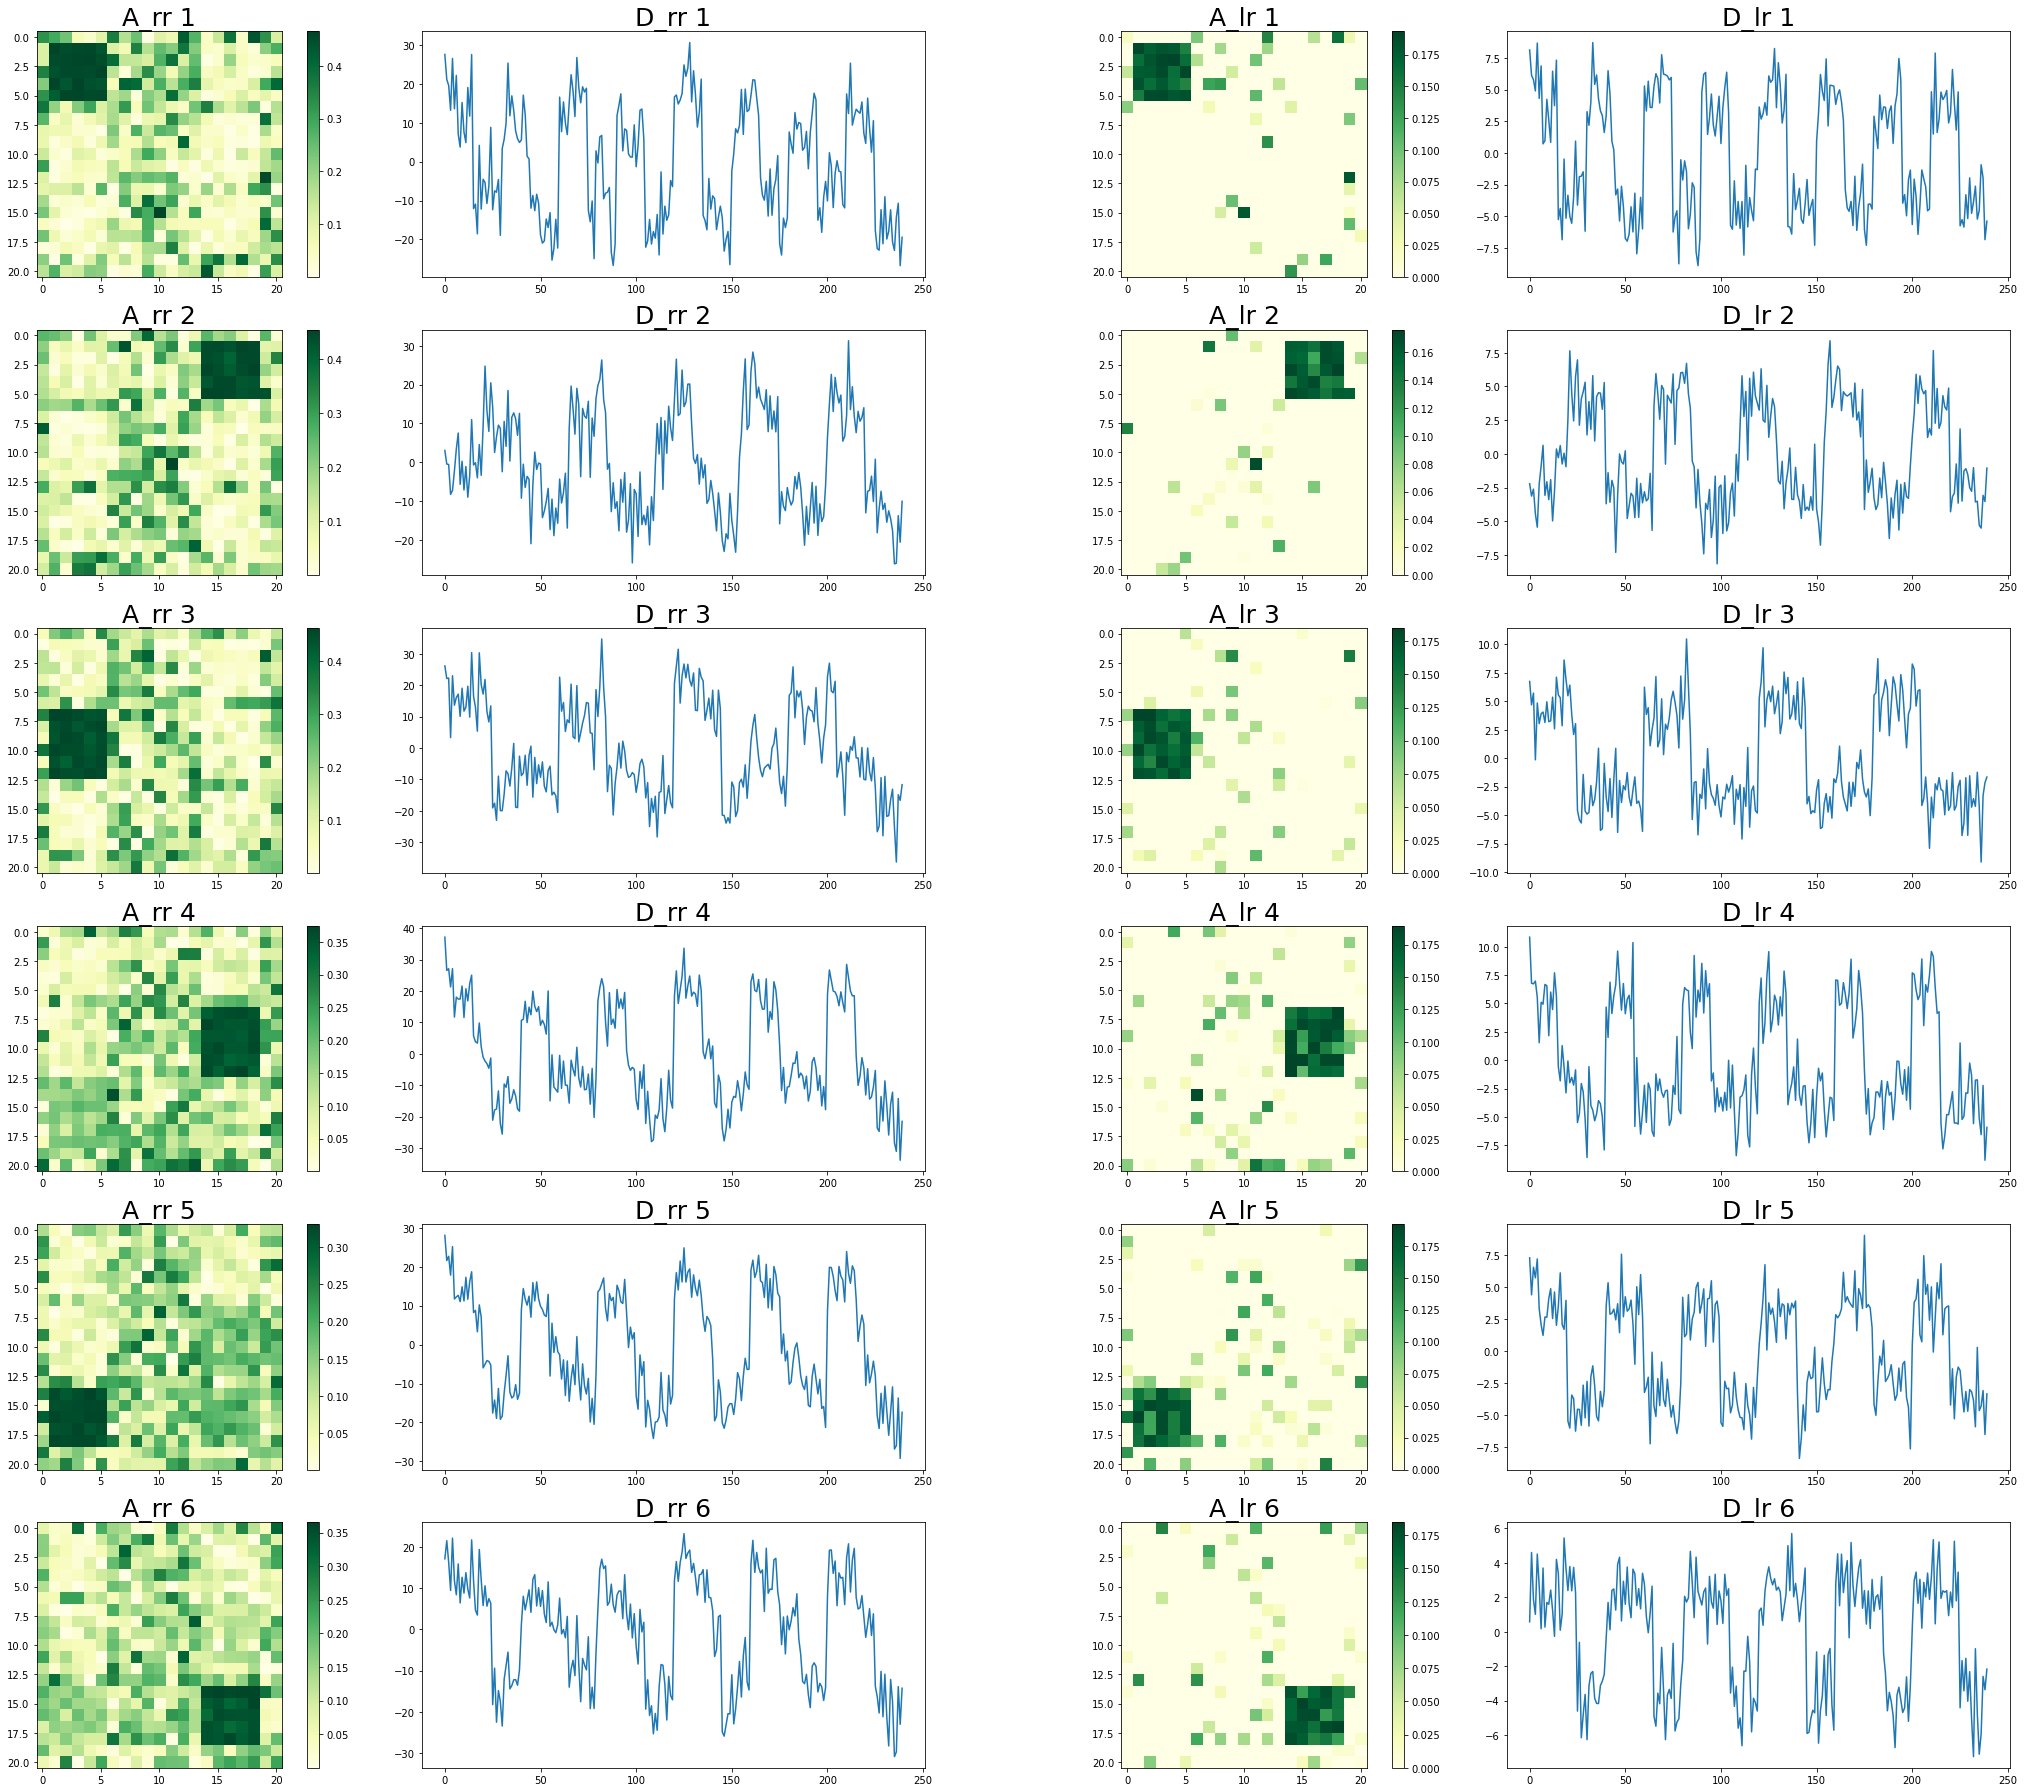

In [20]:
# Plot side by side in form of 4 columns estimates of D and A for both RR and LR
fig = plt.figure(figsize=(30, 25))
j = 0
for i in range(6):
    # plot A_rr
    j+=1
    ax = fig.add_subplot(6, 4, j)
    ax.set_title("A_rr " + str(i+1), fontsize=25)
    plt.imshow(A_rr[i].reshape(21, 21, order='F'), cmap='YlGn')
    plt.colorbar()
    
    # plot D_rr
    j+=1
    ax = fig.add_subplot(6, 4, j)
    ax.set_title("D_rr " + str(i+1), fontsize=25)
    plt.plot(D_rr[:,i])
    
    # plot A_lr
    j+=1
    ax = fig.add_subplot(6, 4, j)
    ax.set_title("A_lr " + str(i+1), fontsize=25)
    plt.imshow(A_lr[i,:].reshape(21, 21, order='F'), cmap='YlGn')
    plt.colorbar()
    
    # plot D_lr
    j+=1
    ax = fig.add_subplot(6, 4, j)
    ax.set_title("D_lr " + str(i+1), fontsize=25)
    plt.plot(D_lr[:,i])
    
plt.tight_layout()
plt.savefig('plots/q2.4b.png')
plt.show()

## Q2.5)
Estimate PCs of the TCs and plot their eigen values. For which PC the eigen value is the smallest? Plot the regressors in Z and source TCs side by side. Did you notice deteriorated shape of PCs? Why the shape of TCs has been lost? Now keeping all components in Z apply lasso regression on X using ρ = 0.001 and then Plot the results of DPCR and APCR side by side (note that APCR = B and your regressors are in Z (PCs of the TCs)). Did you notice the inferior performance of PCR compared to the other three regression models? Why is that so?

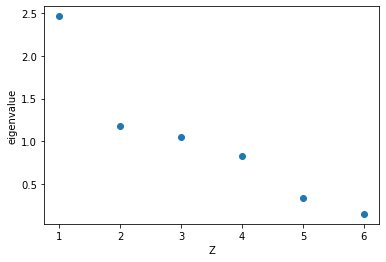

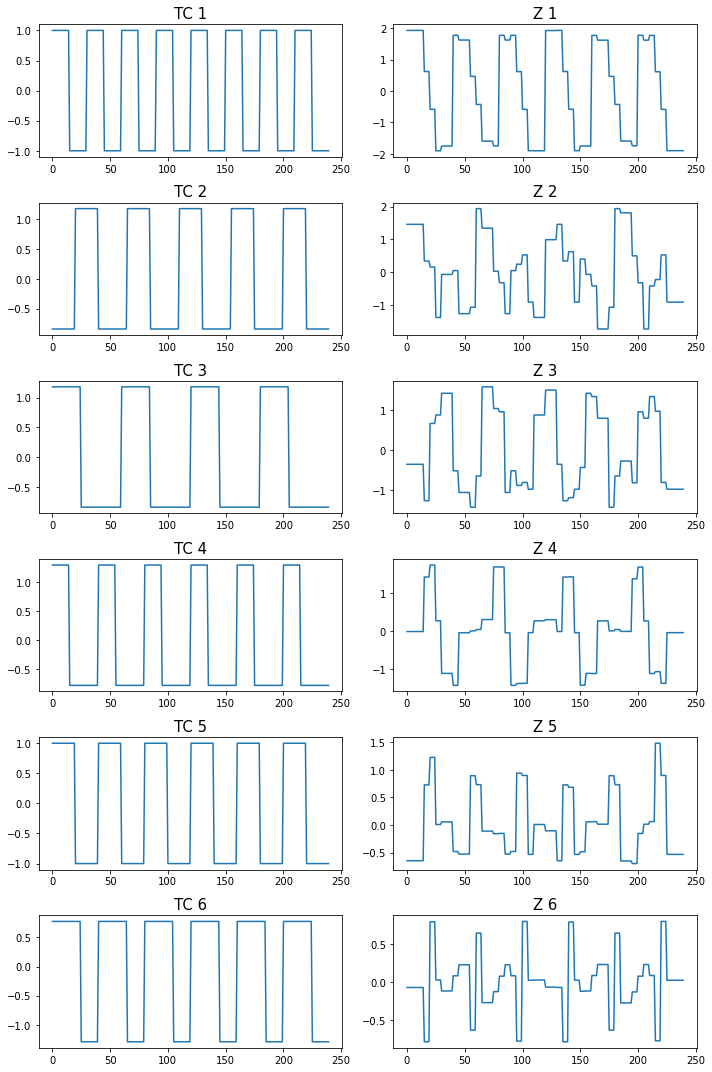

In [21]:
pca = PCA(n_components=6, svd_solver='full')
Z = pca.fit_transform(D)

eig_values = pca.explained_variance_
plt.scatter(x=[1, 2, 3, 4, 5, 6], y=eig_values)
plt.xlabel('Z')
plt.ylabel('eigenvalue')
plt.savefig('plots/q2.5a.png')
plt.show()

# Plot side by side in form of 4 columns estimates of D and A for both RR and LR
fig = plt.figure(figsize=(10, 15))
j = 0
for i in range(6):
    # plot TC i
    j+=1
    ax = fig.add_subplot(6, 2, j)
    ax.set_title("TC " + str(i+1), fontsize=15)
    plt.plot(D[:,i])
    
    # plot Z i
    j+=1
    ax = fig.add_subplot(6, 2, j)
    ax.set_title("Z " + str(i+1), fontsize=15)
    plt.plot(Z[:,i])
    
plt.tight_layout()
plt.savefig('plots/q2.5b.png')
plt.show()

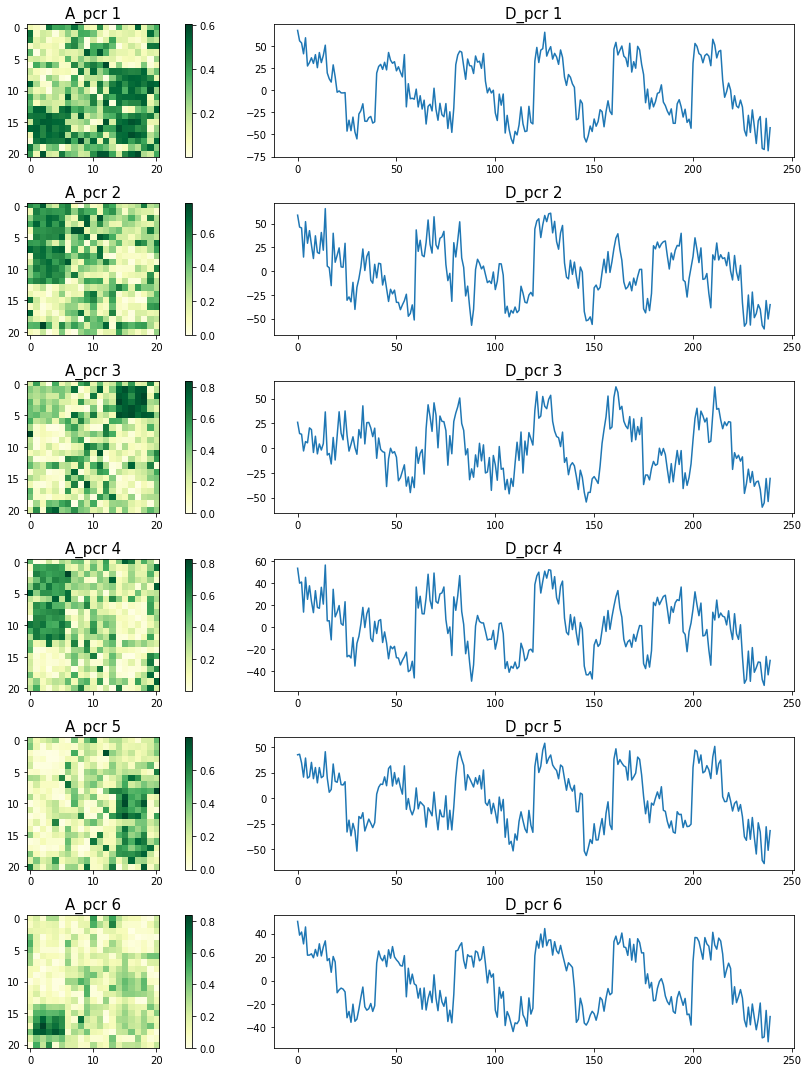

In [22]:
rho = 0.001
A_pcr, D_pcr = estimate_lr_params(TC=Z, rho=rho, X=X)

# Plot six retrieved sources using A_pcr and D_pxr side by side
fig = plt.figure(figsize=(15, 15))
j = 0
for i in range(6):
    # plot A pcr
    j+=1
    ax = fig.add_subplot(6, 2, j)
    ax.set_title("A_pcr " + str(i+1), fontsize=15)
    plt.imshow(np.abs(A_pcr[i]).reshape(21, 21, order='F'), cmap='YlGn')
    plt.colorbar()
    
    # plot D pcr
    j+=1
    ax = fig.add_subplot(6, 2, j)
    ax.set_title("D_pcr " + str(i+1), fontsize=15)
    plt.plot(D_pcr[:,i])
plt.tight_layout()
plt.savefig('plots/q2.5c.png')
plt.show()